I have used the Indian Birds Dataset from which I have used 4 categories: 

 - Cattle Egret

 - Common Kingfisher

 - Coppersmith Barbet

 - Gray Wagtail

https://www.kaggle.com/datasets/ichhadhari/indian-birds

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.stats import mode, pearsonr
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import ResNet50

In [4]:
# Define the dataset folder path
data_folder = "D:\MS\Indiana University Bloomington\Classes\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\Homework\Homework 3 Q2 (Indian Birds Classification)\Dataset"
# Categories (folders for Birds dataset)
categories = ['Cattle_Egret','Common_Kingfisher','Coppersmith_Barbet','Gray_Wagtail']
# Initialize lists to store images and labels
images = []
labels = []

# Iterate through each category folder
for category in categories:
    folder_path = os.path.join(data_folder, category)
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    print(f"Processing folder: {category}")
    
    # List all image files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load the image
            img = Image.open(os.path.join(folder_path, filename)).convert('L')  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 64x64 pixels
            
            # Append the image and its label
            images.append(np.array(img).flatten())  # Flatten the image
            labels.append(category)  # Use the folder name as the label

# Convert lists to numpy arrays
data_matrix = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(data_matrix)} images.")
print(f"Labels: {np.unique(labels)}")

Processing folder: Cattle_Egret
Processing folder: Common_Kingfisher
Processing folder: Coppersmith_Barbet
Processing folder: Gray_Wagtail
Loaded 3546 images.
Labels: ['Cattle_Egret' 'Common_Kingfisher' 'Coppersmith_Barbet' 'Gray_Wagtail']


The images are converted to grayscale, resized to 128 * 128 images and then flattened to a 1D array. They are then converted into a numpy array and stored in a variable 'data_matrix' for easier computation. The labels of the images are appeneded to another list 'labels'

In [5]:
for category in categories:
    folder_path = os.path.join(data_folder, category)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        # Count files in the folder
        num_images = len([file for file in os.listdir(folder_path) if file.endswith(('jpg', 'jpeg', 'png'))])
        print(f"{category}: {num_images} images")
    else:
        print(f"{category}: Folder not found!")

Cattle_Egret: 918 images
Common_Kingfisher: 924 images
Coppersmith_Barbet: 778 images
Gray_Wagtail: 926 images


In [6]:
# Standardize the data matrix
scaler = StandardScaler()
data_matrix_scaled = scaler.fit_transform(data_matrix)

## Q1) Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?

Number of components to preserve 90% variance: 313


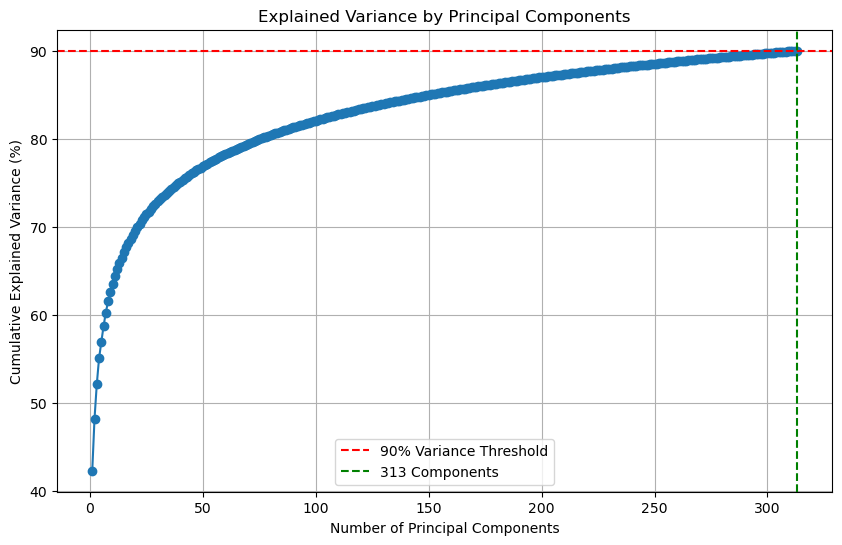

In [8]:
# Perform PCA for 90% explained variance
pca = PCA(0.90)
pca.fit(data_matrix_scaled)
n_components_90_variance = pca.n_components_
print(f"Number of components to preserve 90% variance: {n_components_90_variance}")

# Transform data to reduced dimension
data_matrix_reduced = pca.transform(data_matrix_scaled)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=90, color='r', linestyle='--', label="90% Variance Threshold")
plt.axvline(x=n_components_90_variance, color='g', linestyle='--', label=f"{n_components_90_variance} Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid(True)
plt.show()

90% of the variance is preserved by 313 components.

## Q2) Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA. 

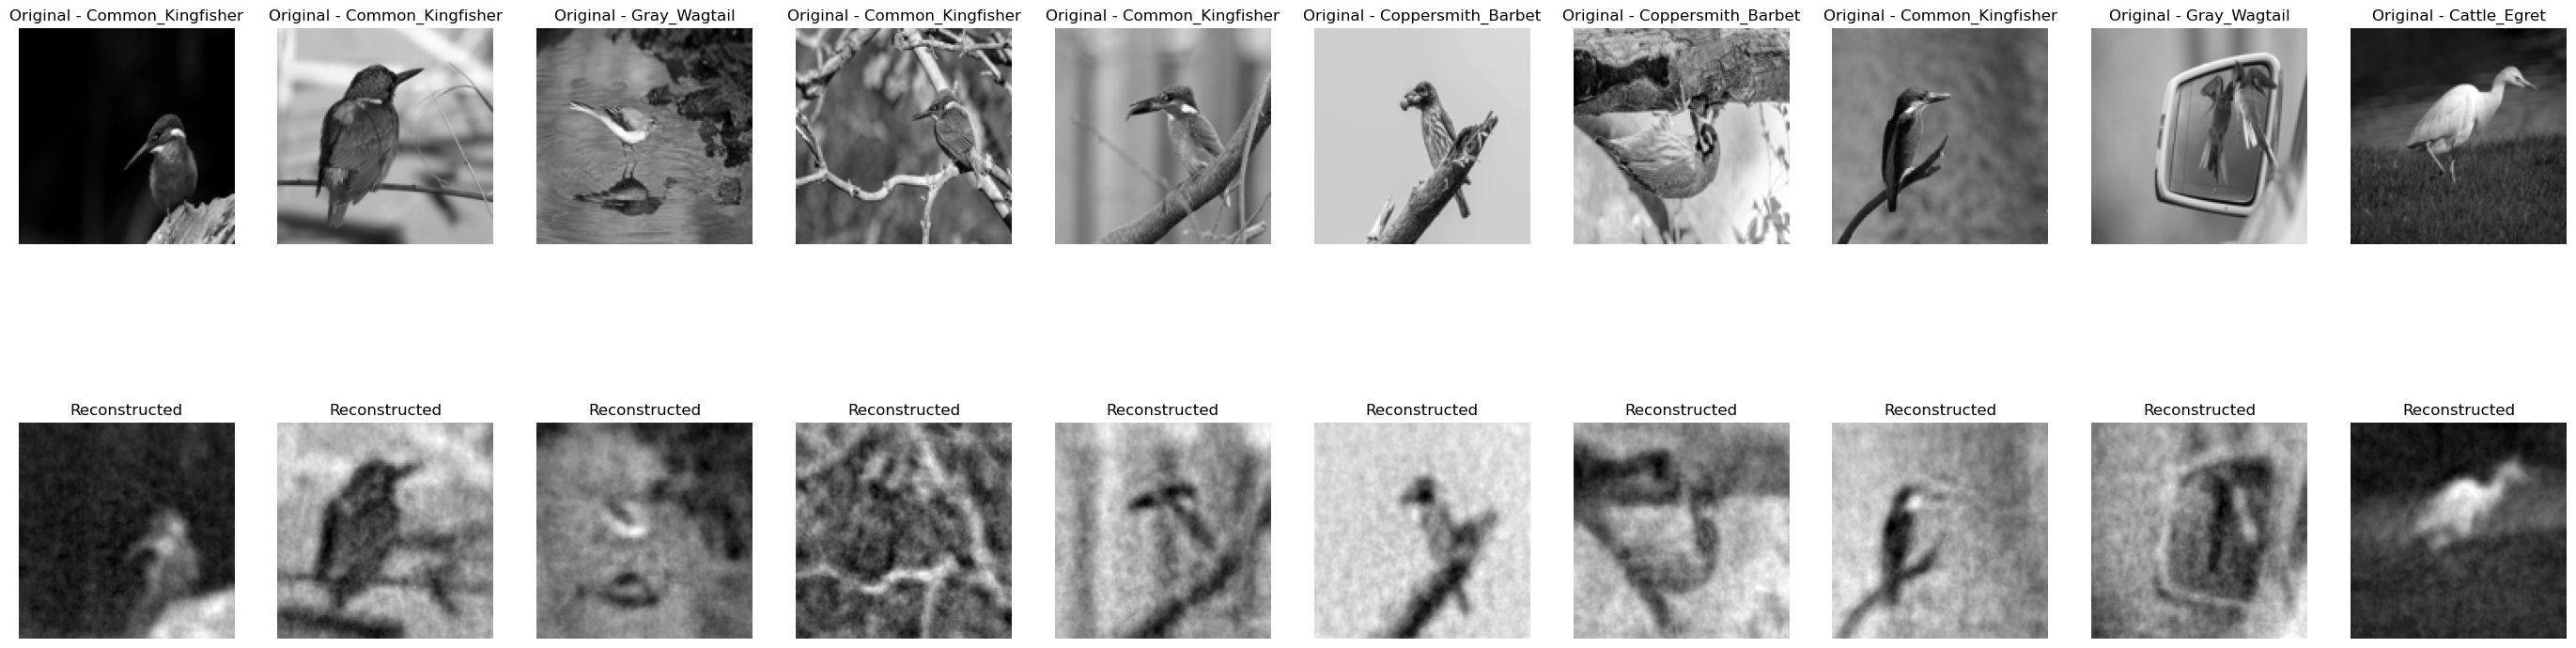

In [11]:
# Reconstruct images with PCA preserving 90% variance
data_matrix_reconstructed = pca.inverse_transform(data_matrix_reduced)

# Select random images to plot
num_images = 10
indices = np.random.choice(len(data_matrix), num_images, replace=False)
selected_images_original = data_matrix[indices]
selected_images_reconstructed = data_matrix_reconstructed[indices]

# Plot original and reconstructed images
plt.figure(figsize=(35, 10))
for i in range(num_images):
    # Original
    plt.subplot(2, num_images, i + 1)
    plt.imshow(selected_images_original[i].reshape(128, 128), cmap="gray")
    plt.axis("off")
    plt.title(f"Original - {labels[indices[i]]}")

    # Reconstructed
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(selected_images_reconstructed[i].reshape(128, 128), cmap="gray")
    plt.axis("off")
    plt.title("Reconstructed")
plt.show()

## Q3) Each of the images belongs to one of four Bird categories. We will now try to see if the visualization can help us identify different clusters.

### a) Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

### b) Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some images to the visualization to better understand what features in the images are accounting for the majority of variance in the data. Repeat the process and create the same type of plots for t-SNE, LLE and MDS. 

### c) Discuss your observations.

Variance explained by the first two components: 48.19%


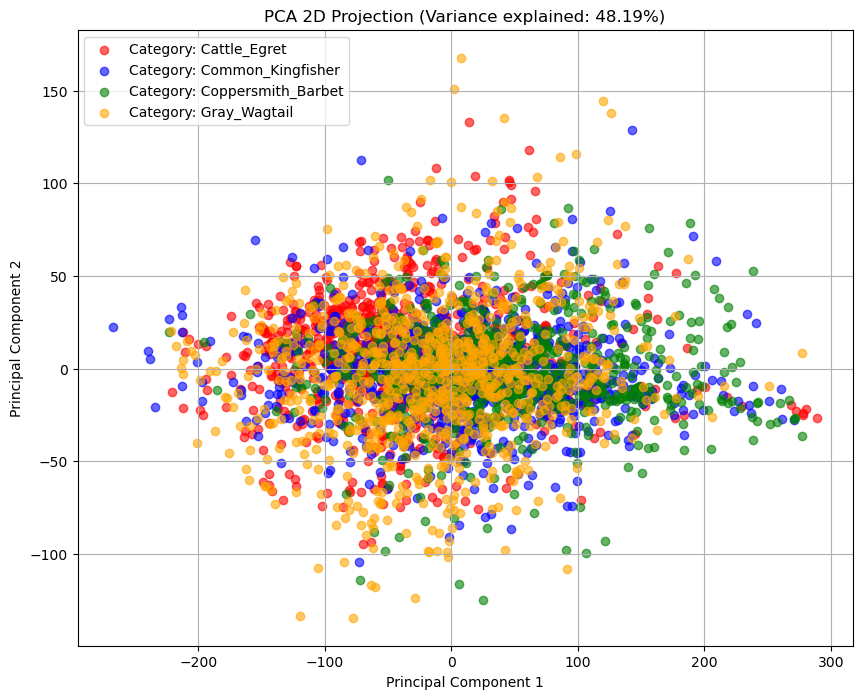

In [13]:
# PCA with 2 components
pca_2d = PCA(n_components=2)
data_matrix_2D_pca = pca_2d.fit_transform(data_matrix_scaled)
explained_variance_2d = np.sum(pca_2d.explained_variance_ratio_) * 100
print(f"Variance explained by the first two components: {explained_variance_2d:.2f}%")

# Define category labels and colors
colors = {
    'Cattle_Egret': 'red',
    'Common_Kingfisher': 'blue',
    'Coppersmith_Barbet': 'green',
    'Gray_Wagtail': 'orange'
}

# Scatter plot of the 2D PCA results
plt.figure(figsize=(10, 8))
for category in categories:
    indices = [i for i, label in enumerate(labels) if label == category]
    plt.scatter(
        data_matrix_2D_pca[indices, 0], 
        data_matrix_2D_pca[indices, 1], 
        label=f"Category: {category}", 
        color=colors[category], 
        alpha=0.6
    )

plt.title(f"PCA 2D Projection (Variance explained: {explained_variance_2d:.2f}%)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Helper function to plot with image overlays
def plot_with_images(X_2D, labels, images, title, min_distance=0.1, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X_2D)
    label_color_map = {'Cattle_Egret': 'red','Common_Kingfisher' : 'blue','Coppersmith_Barbet' : 'green', 'Gray_Wagtail': 'orange'}
    colors = [label_color_map[label] for label in labels]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.scatter(X_normalized[:, 0], X_normalized[:, 1],s=20, c=colors, alpha=0.5, edgecolor='k')

    # Limit number of image overlays
    max_images = 30  # Limit the number of images
    indices = np.random.choice(len(X_normalized), size=min(max_images, len(X_normalized)), replace=False)

    for index in indices:
        img = images[index].reshape(128, 128)
        imagebox = AnnotationBbox(OffsetImage(img, cmap="gray", zoom=0.3), X_normalized[index], frameon=False)
        ax.add_artist(imagebox)

    plt.title(title)
    plt.axis("off")
    plt.show()

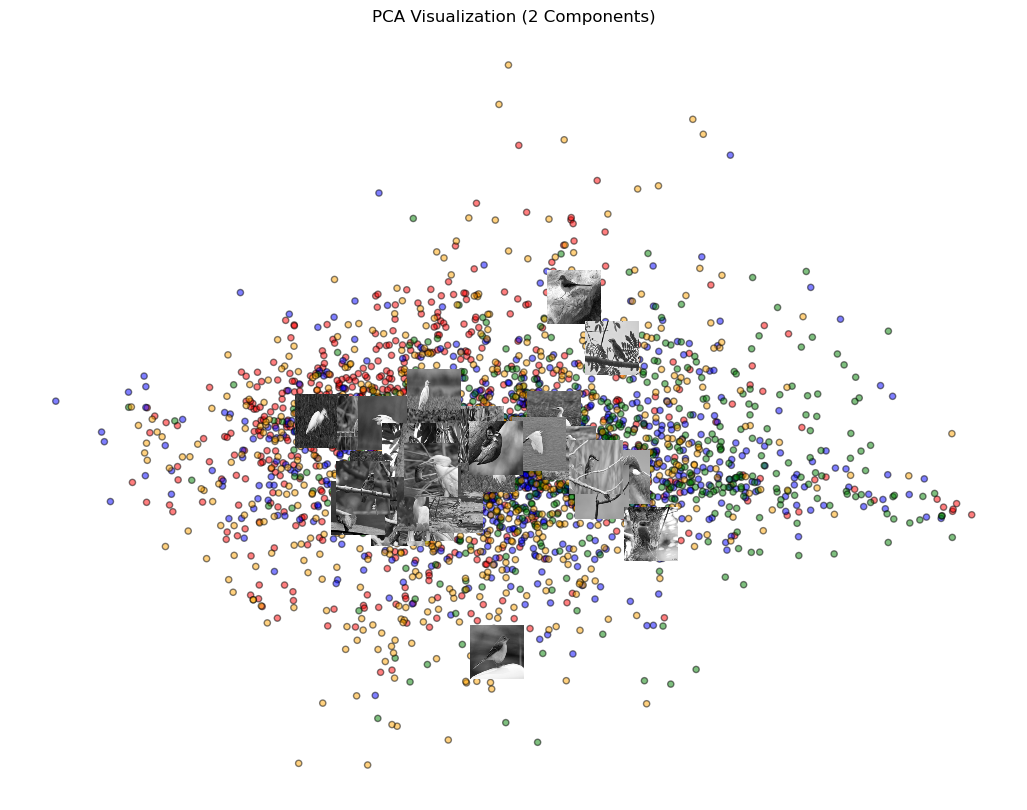

In [15]:
# PCA 2D scatter with image overlays
plot_with_images(data_matrix_2D_pca, labels, data_matrix, "PCA Visualization (2 Components)")

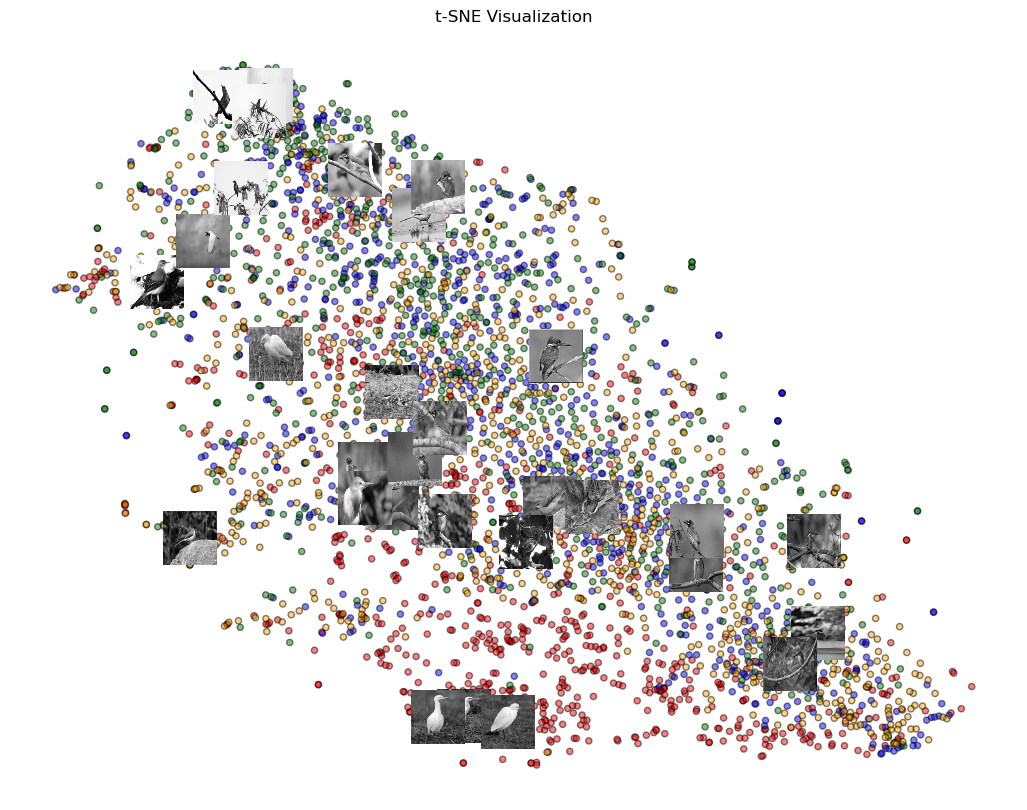

In [16]:
# t-SNE 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_matrix_2D_tsne = tsne.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_tsne, labels, data_matrix, "t-SNE Visualization")

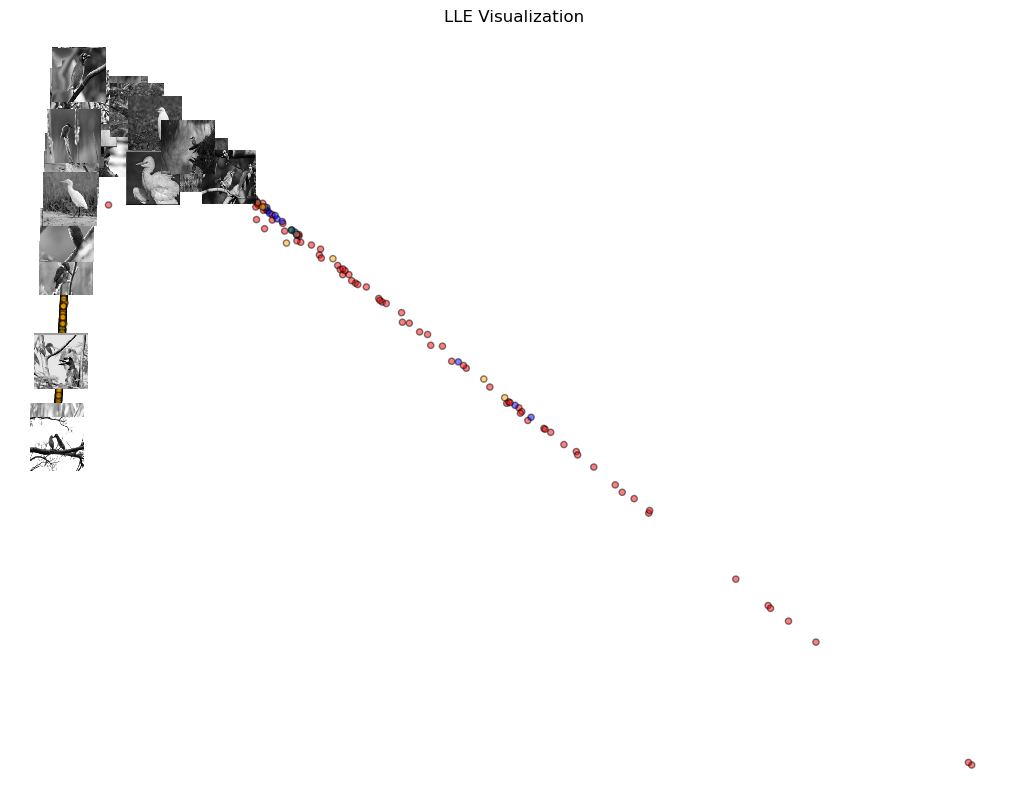

In [17]:
# LLE 2D
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
data_matrix_2D_lle = lle.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_lle, labels, data_matrix, "LLE Visualization")

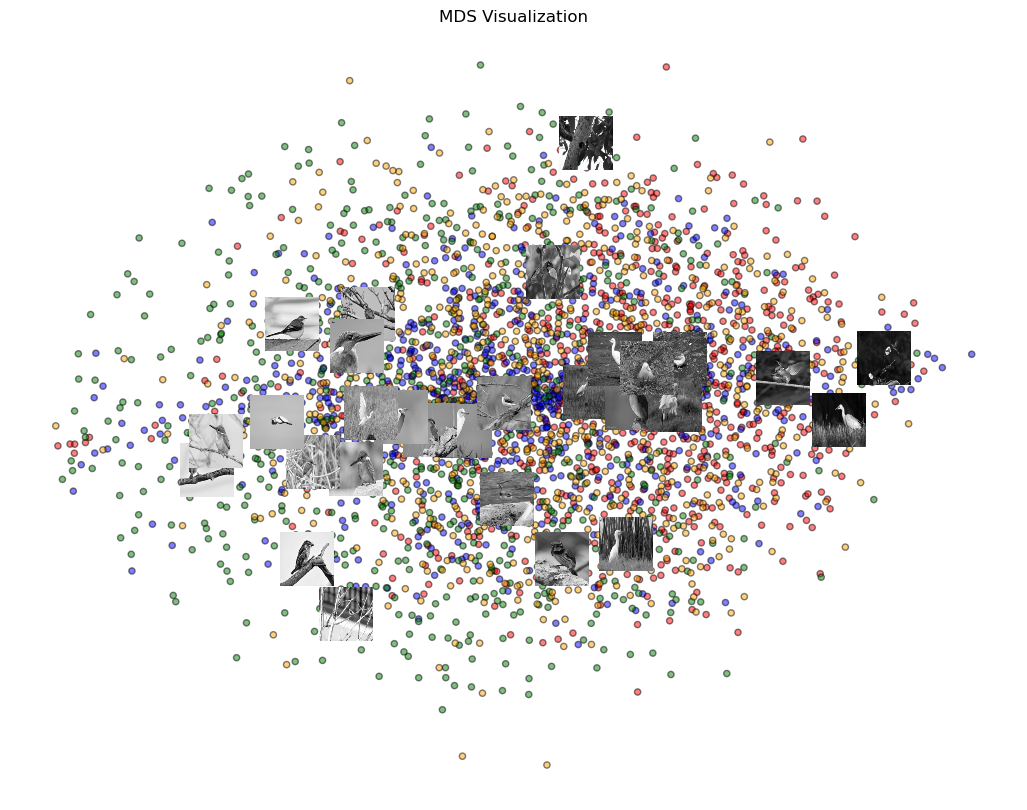

In [18]:
# MDS 2D
mds = MDS(n_components=2, random_state=42)
data_matrix_2D_mds = mds.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_mds, labels, data_matrix, "MDS Visualization")

**Q3) c)**

PCA Visualization (2 Components):
This image shows a 2D scatter plot visualization of the PCA (Principal Component Analysis) performed on the dataset. Each data point represents an instance from the dataset, and the colors/shapes seem to indicate different categories or classes of birds. The overlapping points suggest that the 2 principal components chosen may not be sufficient to fully separate the different bird classes.

t-SNE Visualization:
The t-SNE (t-Distributed Stochastic Neighbor Embedding) visualization shows a more dispersed and granular representation of the dataset. The different bird classes appear to be better separated compared to the PCA plot, indicating that t-SNE was able to capture more of the underlying structure and relationships in the high-dimensional data.

LLE Visualization:
The LLE (Locally Linear Embedding) visualization presents the data in a more linear, trail-like arrangement. This suggests that the LLE algorithm was able to uncover some underlying manifold or low-dimensional structure in the data that is not easily represented in a 2D scatter plot.

MDS Visualization:
The MDS (Multidimensional Scaling) plot shows a more scattered distribution of the data points, with some clustering of the different bird classes. This technique seems to have preserved more of the relative distances between data points compared to the other dimensionality reduction methods.

## Q5) Cluster the 360 images using K-Means.

### a) You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class. 

### b) Set the number of clusters to 3 and report clustering accuracy

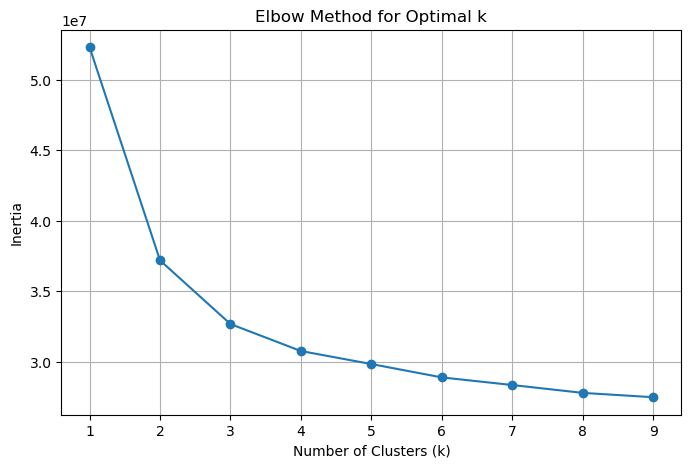

In [21]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_matrix_reduced)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

We have used the elbow method (plotting the inertia w.r.t. the number of clusters) to detremine the appropriate number of clusters. The optimal number of clusters (where the elbow is formed) is 3.

In [23]:
# Apply K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(data_matrix_reduced)

# Convert true labels to numerical format
label_mapping = {'Cattle_Egret': 0,'Common_Kingfisher' : 1,'Coppersmith_Barbet' : 2, 'Gray_Wagtail': 3}
true_labels = np.array([label_mapping[label] for label in labels])

# Map each cluster label to true label using majority voting
mapped_labels_kmeans = np.zeros_like(cluster_labels_kmeans)
for i in range(3):
    mask = (cluster_labels_kmeans == i)
    mapped_labels_kmeans[mask] = mode(true_labels[mask])[0]

# Calculate accuracy
accuracy_kmeans = accuracy_score(true_labels, mapped_labels_kmeans)
print(f"K-Means Clustering Accuracy with k=3: {accuracy_kmeans * 100:.2f}%")

K-Means Clustering Accuracy with k=3: 34.63%


## Q6) Cluster the 360 images using EM.

### a) You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class. 

### b) Set the number of clusters to 3 and report clustering accuracy. 

### c) Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).  

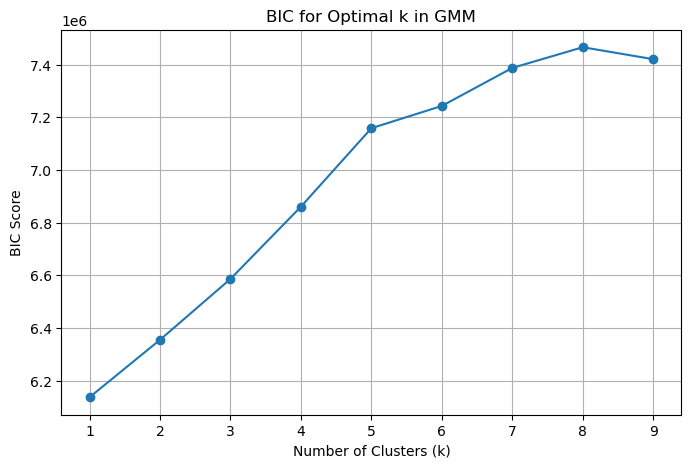

In [25]:
bic_scores = []
K_range = range(1, 10)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_matrix_reduced)
    bic_scores.append(gmm.bic(data_matrix_reduced))

# Plot BIC scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("BIC for Optimal k in GMM")
plt.grid(True)
plt.show()

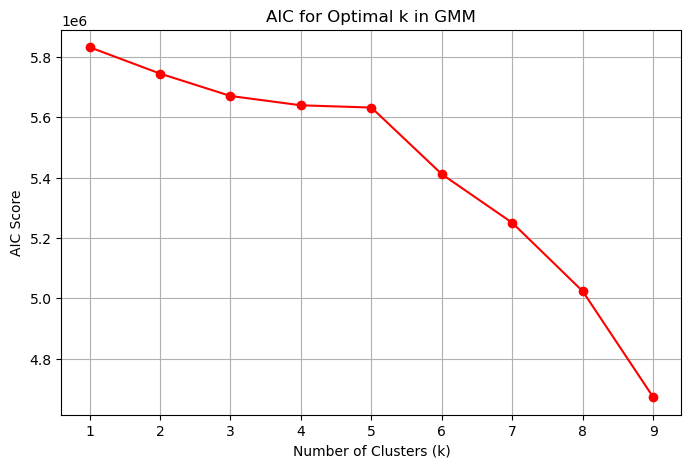

In [26]:
aic_scores = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_matrix_reduced)  
    aic_scores.append(gmm.aic(data_matrix_reduced))  

# Plot AIC scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, aic_scores, marker='o', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("AIC Score")
plt.title("AIC for Optimal k in GMM")
plt.grid(True)
plt.show()

The Bayesian Information Criterion, the score increases as the number of clusters increases, and the curve begins to flatten after k=7. 

For the Akaike Information Criterion, The AIC score decreases consistently with increasing clusters. Unlike BIC, there is no clear flattening, but the rate of decrease is less pronounced after k = 7.

Based on the BIC plot, the optimal number of clusters appears to be 7, as it balances model complexity and goodness of fit.

In [27]:
# Fit GMM with k=3
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(data_matrix_reduced)

# Map GMM cluster labels to true labels using majority voting
mapped_labels_gmm = np.zeros_like(gmm_labels)
for i in range(3):
    mask = (gmm_labels == i)
    mapped_labels_gmm[mask] = mode(true_labels[mask])[0]

# Calculate accuracy
accuracy_gmm = accuracy_score(true_labels, mapped_labels_gmm)
print(f"GMM Clustering Accuracy with k=3: {accuracy_gmm * 100:.2f}%")

GMM Clustering Accuracy with k=3: 37.87%


Shape of new_samples_original: (20, 16384)


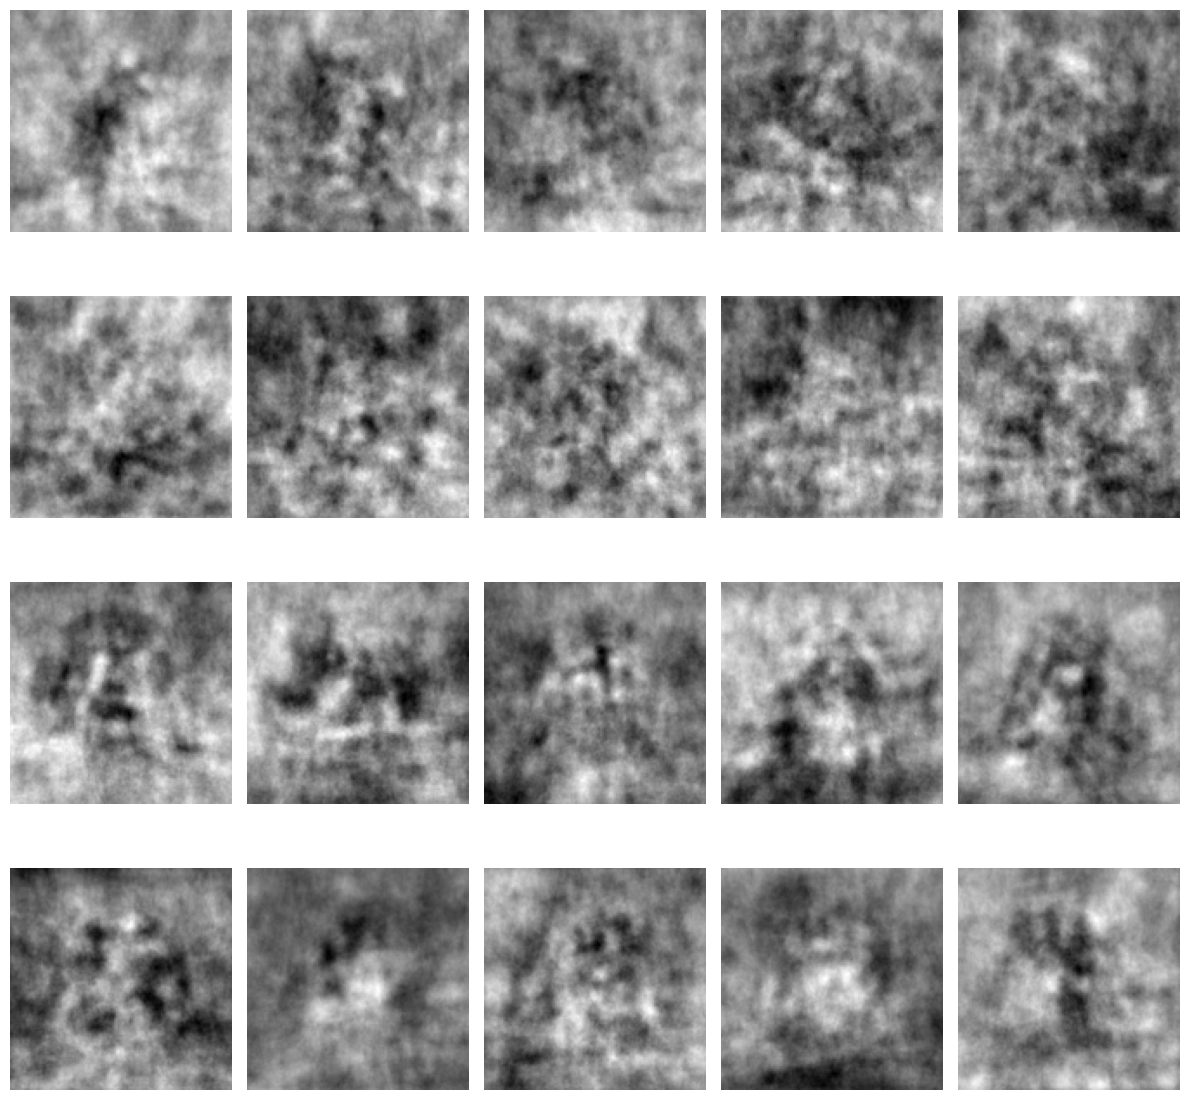

In [28]:
# Generate 20 new samples using the GMM model
num_samples = 20
new_samples_reduced, _ = gmm.sample(num_samples) 

# Inverse transform the reduced samples back to the original image space
new_samples_original = pca.inverse_transform(new_samples_reduced)

# Check the shape of new_samples_original
print(f"Shape of new_samples_original: {new_samples_original.shape}")

# Visualize the 20 new "rocks"
fig, axes = plt.subplots(4, 5, figsize=(12, 12))  # 4 rows, 5 columns for 20 images
axes = axes.flatten()

# Loop through and visualize the new samples
for i in range(num_samples):
    axes[i].imshow(new_samples_original[i].reshape(128,128), cmap='gray')  
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

## Q7) Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on the images. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training. We recommend using Colab (the free version should be totally fine), but make sure to run it with a GPU to speed up the training - to add a GPU on Colab go to Edit->Notebook settings)

### A) Report the training time (use code to do this). 

### B) Plot training and validation loss and accuracy as a function of training epochs. 

### C) How many parameters does the network have? How many of those parameters are bias parameters?

In [30]:
categories = ['Cattle_Egret', 'Common_Kingfisher', 'Coppersmith_Barbet', 'Gray_Wagtail']

# Assuming `data_matrix` contains image data and `labels` contains corresponding labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Convert labels to integers
one_hot_labels = to_categorical(encoded_labels)  # One-hot encode the labels


In [31]:
# Perform stratified 80-20 train-validation split
train_images, val_images, train_labels, val_labels = train_test_split(
    data_matrix, one_hot_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

train_images = (train_images - train_images.min()) / (train_images.max() - train_images.min())
val_images = (val_images - val_images.min()) / (val_images.max() - val_images.min())

# Reshape the data to match the input shape expected by the model
train_images = train_images.reshape(-1, 128, 128, 1)  # Update shape as per your dataset
val_images = val_images.reshape(-1, 128, 128, 1)

# Verify the split
print(f"Training images: {train_images.shape}")
print(f"Validation images: {val_images.shape}")
print(f"Train Labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"Training labels distribution: {np.sum(train_labels, axis=0)}")
print(f"Validation labels distribution: {np.sum(val_labels, axis=0)}")

Training images: (2836, 128, 128, 1)
Validation images: (710, 128, 128, 1)
Train Labels shape: (2836, 4)
val_labels shape: (710, 4)
Training labels distribution: [734. 739. 622. 741.]
Validation labels distribution: [184. 185. 156. 185.]


Category: Cattle_Egret, Count: 184
Category: Common_Kingfisher, Count: 185
Category: Coppersmith_Barbet, Count: 156
Category: Gray_Wagtail, Count: 185


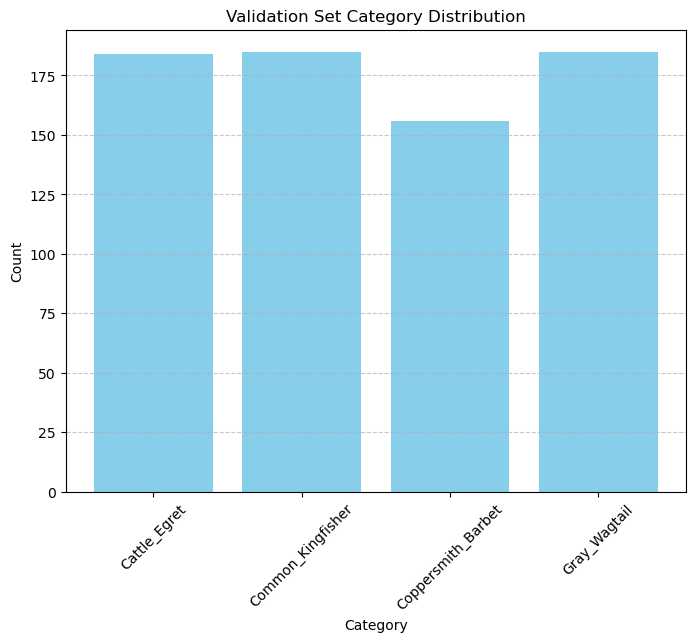

In [32]:
# Decode one-hot encoded labels to original category indices
val_labels_decoded = np.argmax(val_labels, axis=1)  # Get the class indices from one-hot labels

# Get category counts in the validation set
val_category_distribution = np.bincount(val_labels_decoded, minlength=len(label_encoder.classes_))

# Print the distribution of categories
for category, count in zip(label_encoder.classes_, val_category_distribution):
    print(f"Category: {category}, Count: {count}")

# Optional: Display the distribution as a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(label_encoder.classes_, val_category_distribution, color='skyblue')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Validation Set Category Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [33]:
# Define the input shape and number of classes
input_shape = (128, 128, 1)  # Assuming RGB bird images
num_classes = len(label_encoder.classes_)

# Neural network architecture
inputs = Input(shape=input_shape)

# Convolutional block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional block 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Global Average Pooling and Dense layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)  # Dropout to prevent overfitting
x = Dense(64, activation='relu')(x)
x = Dense(8, activation='relu')(x)  # Next-to-last layer with 8 neurons

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,996 (460.92 KB)

 Trainable params: 117,996 (460.92 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
start_time = time.time()
history = model.fit(
    train_images, 
    train_labels, 
    epochs=30, 
    batch_size=32, 
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping]  # Add early stopping here
)
end_time = time.time()

# Training time
training_time = end_time - start_time
print(f"Training Time with Early Stopping: {training_time:.2f} seconds")


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.2294 - loss: 1.3858 - val_accuracy: 0.2606 - val_loss: 1.3779
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.2938 - loss: 1.3662 - val_accuracy: 0.3296 - val_loss: 1.3128
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.3071 - loss: 1.3061 - val_accuracy: 0.3789 - val_loss: 1.2784
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.3758 - loss: 1.2765 - val_accuracy: 0.4127 - val_loss: 1.2711
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.4403 - loss: 1.2439 - val_accuracy: 0.3972 - val_loss: 1.2759
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.4226 - loss: 1.2435 - val_accuracy: 0.4634 - val_loss: 1.2093
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - accuracy: 0.4657 - loss: 1.1923 - val_accuracy: 0.4549 - val_loss: 1.2016
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.4677 - loss: 1.1997 - val_accu

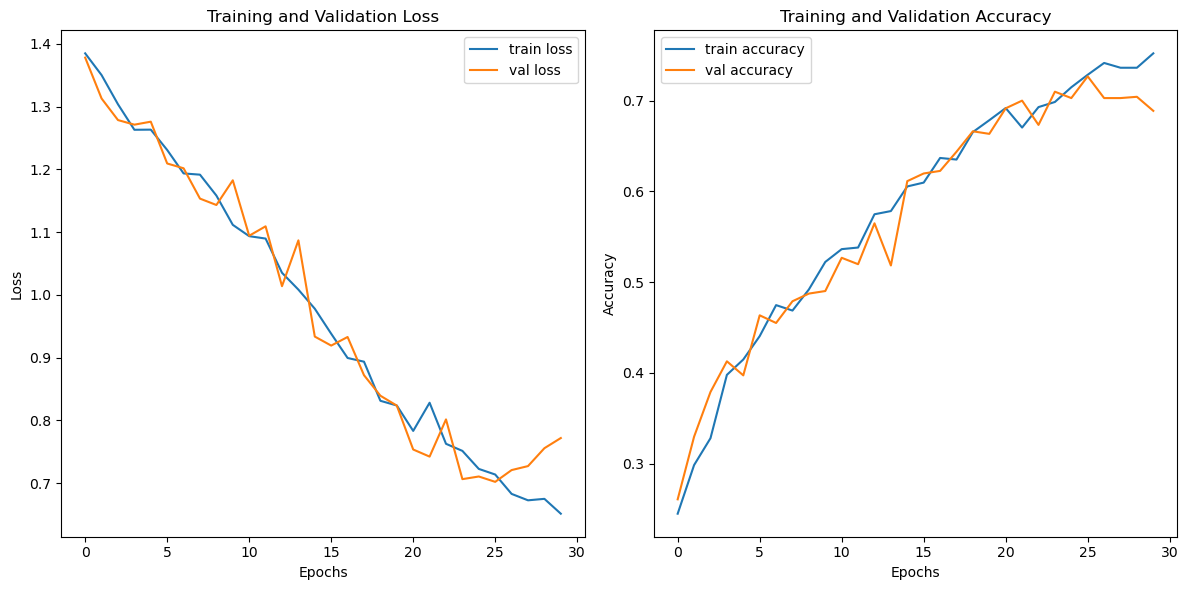

In [35]:
# Plot training and validation loss and accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Both training and validation accuracy increase consistently across epochs and the the loss decreases gradually, showing that the model is learning effectively.

In [36]:
# Calculate the total number of parameters
total_params = model.count_params()

# Calculate the number of bias parameters
bias_params = sum(np.prod(p.shape) for p in model.trainable_weights if 'bias' in p.name)

print(f"Total parameters: {total_params}")
print(f"Bias parameters: {bias_params}")

Total parameters: 117996
Bias parameters: 428
